In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
import sys
import pandas as pd
import seaborn as sns
import networkx as nx
import yaml
import os
from networkx.algorithms import approximation as nx_approx
from tqdm.notebook import tqdm
from copy import deepcopy
# Adding path to module
sys.path.append("../")
# picture path
PICS = '../pics/'
import scipy.stats
# Module imports
from contagion import Contagion, config
from contagion.config import _baseconfig
from contagion.plotting import plot_infection_history


In [2]:
cpp_config = {
    "DaysBackwardTrace": 14, 
    "TestPositiveProbability": 0.9, 
    "OutputPrefix": "CovidMC_1346", 
    "AppProbability": 1.0, 
    "DaysToTestResult": 0, 
    "FalsePositiveRate": 0.01, 
    "NDays": 500, 
    "SymptomProbability": 0.6, 
    "SocialDistancingFactor": 1.0, 
    "SocialDistancingTo": 99999, 
    "BackwardTracing": True, 
    "dTTest": 5, 
    "PeopleMetPerDay": 10.0, 
    "DaysInQuarantine": 14, 
    "TraceUninfected": True, 
    "AsymptomaticTransmissionScaling": 1.0, 
    "StartTracingTestingInfectedFraction": 0.004, 
    "SocialDistancingFrom": 99999, 
    "TransmissionProbability": 0.0287, 
    "NPersons": 100000, 
    "TracingOrder": 1, 
    "IncubationPeriod": {
        "mu": 0, 
        "beta": 2.44, 
        "gamma": 3.06
    }, 
    "TestThreshold": 0.01, 
    "tracingEfficiency": 1.0, 
    "SocialDistancingMaxPeople": 60, 
    "Infectivity": {
        "mu": -2.42, 
        "beta": 1.56, 
        "gamma": 2.08
    }, 
    "TracingDelay": 0, 
    "ReportingProbability": 1.0
}
incub_pdf = scipy.stats.gamma(cpp_config["IncubationPeriod"]["gamma"], scale=cpp_config["IncubationPeriod"]["beta"])
infect_pdf = scipy.stats.gamma(
    cpp_config["Infectivity"]["gamma"],
    scale=cpp_config["Infectivity"]["beta"],
    )

ppl_met_per_day_pdf = scipy.stats.gamma(2, scale=cpp_config["PeopleMetPerDay"]/2)

In [3]:
scipy.stats.binom(1, 0.5).rvs(100)

array([1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1])

In [4]:
my_config = dict(_baseconfig)

my_config["general"]["random state seed"] = 6
my_config["general"]["track graph history"] = True
my_config["general"]["debug level"] = 50
my_config["general"]["trace spread"] = True
my_config["population"]["population class"] = "NetworkXPopulation"
#my_config["population"]["population class"] = "HomogeneousPopulation"
my_config["population"]["social circle interactions pdf"] = {
    "mean": cpp_config["PeopleMetPerDay"],
    "class": "Gamma",
    "mean": ppl_met_per_day_pdf.mean(),
    "sd": ppl_met_per_day_pdf.std(), 
}
my_config["population"]["social circle pdf"] = {
    "mean": cpp_config["PeopleMetPerDay"],
    "class": "Gamma",
    "mean": ppl_met_per_day_pdf.mean(),
    "sd": ppl_met_per_day_pdf.std(), 
}




my_config["measures"]["contact tracing"] = True
my_config["measures"]["tracked fraction"] = 0 #cpp_config["AppProbability"]
my_config["measures"]["second order"] = cpp_config["TracingOrder"] == 2
my_config["measures"]["backtrack length"] = cpp_config["DaysBackwardTrace"]
my_config["measures"]["track uninfected"] = cpp_config["TraceUninfected"]
my_config["measures"]["quarantine"] = True
my_config["measures"]["report symptomatic"] = True
my_config["measures"]["quarantine duration"] = cpp_config["DaysInQuarantine"]
my_config["measures"]["testing"] = True
my_config["measures"]["time until test"] = 0
my_config["measures"]["time until result"] = cpp_config["DaysToTestResult"]
my_config["measures"]["time until second test"] = cpp_config["dTTest"]+1
my_config["measures"]["time until second test result"] = 0
my_config["measures"]["test true positive rate"] = cpp_config["TestPositiveProbability"]
my_config["measures"]["test false positive rate"] = cpp_config["FalsePositiveRate"]
my_config["measures"]["test threshold"] = cpp_config["TestThreshold"]
my_config["measures"]["app fraction"] = cpp_config["AppProbability"]

my_config["scenario"]["sim_length"] = 500
my_config['infection']['infected'] = 1
my_config["infection"]["infection probability pdf"] = {
    "class": "Gamma",
    "scaling": (infect_pdf.ppf(0.99))*cpp_config["TransmissionProbability"],
    "mean":  infect_pdf.mean(),
    "sd":  infect_pdf.std()
}
my_config['infection']["hospitalization probability pdf"] = {
    'mean':  0,
    "class": "Delta"
}
my_config['infection']['will have symptoms prob pdf'] = {
    'mean': cpp_config["SymptomProbability"],
    "class": "Delta"
}


my_config["infection"]["infectious duration pdf"] = {
    "mean": infect_pdf.ppf(0.99),
    "class": "Delta"
}

my_config["infection"]["latency duration pdf"] = {
    "mean": -cpp_config["Infectivity"]["mu"],
    "class": "Delta"
}

my_config["infection"]["incubation duration pdf"]["mean"] = incub_pdf.mean()
my_config["infection"]["incubation duration pdf"]["sd"] = incub_pdf.std()


my_config["population"]["random interactions pdf"] = {
    "mean": 0.0,
    "class": "Delta"
}

my_config["population"]["random interactions intensity pdf"]= {
    "mean": 0.0,
    "class": "Delta"
}

my_config["population"]["population size"] = cpp_config["NPersons"]

my_config["population"]["nx"]["func"] = "lfr_ba"
my_config["population"]["nx"]["kwargs"] = {
                "m": 3,
                "tau": 1.2,
                "mu": 0.1,
                "min_community": 13,
                #"max_community": 40,
                "max_iters": 4000,
                "tolerance": 0.1,
                "pref_attach": True
}
my_config["population"]["nx"]["inter freq pdf"] = {
    "mean": cpp_config["PeopleMetPerDay"],
    "class": "Gamma",
    "mean": ppl_met_per_day_pdf.mean(),
    "sd": ppl_met_per_day_pdf.std(), 
}
my_config["population"]["nx"]["intra freq pdf"] = {
    "mean": cpp_config["PeopleMetPerDay"],
    "class": "Gamma",
    "mean": ppl_met_per_day_pdf.mean(),
    "sd": ppl_met_per_day_pdf.std(), 
}
my_config["population"]["random interactions pdf"] = {"class": "Delta", "mean": 0.000}
my_config["scenario"]["class"] = "LateMeasures"
my_config["scenario"]["start_measures_inf_frac"] = cpp_config["StartTracingTestingInfectedFraction"]


In [5]:
yaml.dump(my_config, open("test_social_graph_cpp_params.yaml", "w"))

In [6]:
def sim_config(conf, n=10):
    if not os.path.exists(conf["population"]["population storage"]):
        conf["population"]["store population"] = True
        #my_config["population"]["population storage"] = "1E6_lfr_ba.pickle"
        conf["population"]["re-use population"] = False
        contagion = Contagion(conf)
    conf["population"]["re-use population"] = True
    conf["population"]["store population"] = False
    
    results = []
    for i in range(n):
        conf["general"]["random state seed"] = i
        contagion = Contagion(conf)

        contagion.sim()
        results.append(pd.DataFrame(contagion.statistics))
    return results

    

In [7]:
conf_1 = deepcopy(my_config)
conf_1["population"]["population class"] = "HomogeneousPopulation"
conf_1["population"]["population storage"] = "../populations/1E6_homog.pickle"

conf_2 = deepcopy(my_config)
conf_2["population"]["population class"] = "NetworkXPopulation"
conf_2["population"]["nx"]["func"] = "lfr_ba"
conf_2["population"]["nx"]["kwargs"]["m"] = 3
conf_2["population"]["population storage"] = "../populations/1E6_lfr_ba_m3.pickle"

conf_3 = deepcopy(my_config)
conf_3["population"]["population class"] = "NetworkXPopulation"
conf_3["population"]["nx"]["func"] = "lfr_ba"
conf_3["population"]["nx"]["kwargs"]["m"] = 4
conf_3["population"]["population storage"] = "../populations/1E6_lfr_ba_m4.pickle"

conf_4 = deepcopy(my_config)
conf_4["population"]["population class"] = "NetworkXPopulation"
conf_4["population"]["nx"]["func"] = "lfr_ba"
conf_4["population"]["nx"]["kwargs"]["m"] = 5
conf_4["population"]["population storage"] = "../populations/1E6_lfr_ba_m5.pickle"

conf_5 = deepcopy(my_config)
conf_5["population"]["population class"] = "NetworkXPopulation"
conf_5["population"]["nx"]["func"] = "hierarchical_lfr_ba"
conf_5["population"]["nx"]["kwargs"]["m"] = 3
conf_5["population"]["nx"]["kwargs"]["mu_hier"] = 0.3
conf_5["population"]["nx"]["kwargs"]["tau_graphs"]= 3
conf_5["population"]["nx"]["kwargs"]["min_graph"] = 5000
conf_5["population"]["nx"]["kwargs"]["max_graph"] = 200000
conf_5["population"]["nx"]["kwargs"]["max_iters"] = 50000
conf_5["population"]["population storage"] = "../populations/1E6_hier_lfr_ba_m3_taug3.pickle"

conf_6 = deepcopy(my_config)
conf_6["population"]["population class"] = "NetworkXPopulation"
conf_6["population"]["nx"]["func"] = "lfr_ba"
conf_6["population"]["nx"]["kwargs"]["m"] = 5
conf_6["population"]["nx"]["kwargs"]["mu"] = 0.5
conf_6["population"]["population storage"] = "../populations/1E6_lfr_ba_m5_mu_0.5.pickle"

configs = [conf_1, conf_2, conf_3, conf_4, conf_5, conf_6]



In [8]:
import cProfile


In [56]:
conf_test = deepcopy(conf_1)
conf_test["population"]["population size"] = 100000
conf_test["population"]["re-use population"] = False
conf_test["general"]["trace states"] = True
conf_test["general"]["random state seed"] = 7
conf_test["scenario"]["sim_length"] = 500
conf_test["scenario"]["early_stopping"] = False
conf_test["measures"]["app fraction"] = 1
conf_test["measures"]["test false positive rate"] = 0
conf_test["measures"]["rnd testing"] = False
conf_test["measures"]["random test num"] = 10
#conf_test["measures"]["quarantine"] = False
#conf_test["measures"]["conact tracing"] = False
contagion = Contagion(conf_test)
prof = cProfile.Profile()
prof.enable()
contagion.sim()
prof.disable()
prof.dump_stats("profile.stats")
stats = pd.DataFrame(contagion.statistics)

In [57]:
data_cpp = pd.read_csv("Sum_CovidSimMC_1346.csv")

(0, 500)

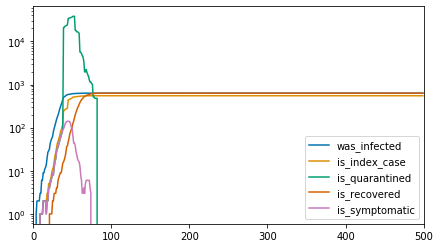

In [58]:
plt.figure(figsize=(7, 4))
colors = sns.color_palette("colorblind", 8)

fields = ["was_infected", "is_index_case", "is_quarantined", "is_recovered", "is_symptomatic"]

for field, color in zip(fields, colors):
    plt.plot(stats[field], color=color, label=field)
plt.legend()
plt.semilogy()
plt.xlim(0, 500)

In [55]:
df = pd.DataFrame(contagion.traced_states[58])
df.loc[df["is_index_case"] & ~df["was_infected"] , ["is_quarantined", "is_tested", "is_tested_negative", "is_tested_second", "time_until_second_test",
                              "is_tested_negative_second", "time_since_last_test_result", "has_second_test_result", "is_tested_positive_second",
                              "is_tested_second", "was_infected"]]

,is_quarantined,is_tested,is_tested_negative,is_tested_second,time_until_second_test,is_tested_negative_second,time_since_last_test_result,has_second_test_result,is_tested_positive_second,is_tested_second,was_infected


(0, 500)

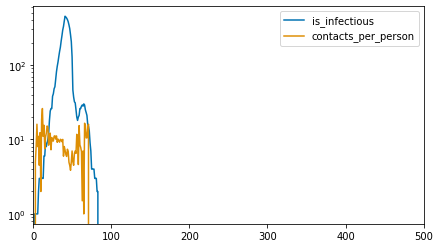

In [27]:
plt.figure(figsize=(7, 4))
colors = sns.color_palette("colorblind", 8)

fields = ["is_infectious", "contacts_per_person"]

for field, color in zip(fields, colors):
    plt.plot(stats[field], color=color, label=field)
plt.legend()
plt.semilogy()
plt.xlim(0, 500)

(0, 100)

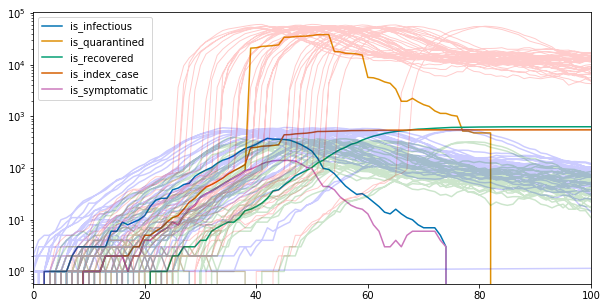

In [59]:
plt.figure(figsize=(10, 5))
colors = sns.color_palette("colorblind", 8)

fields = ["is_infectious", "is_quarantined", "is_recovered", "is_index_case", "is_symptomatic"]

for field, color in zip(fields, colors):
    plt.plot(stats[field], color=color, label=field)
plt.legend()
plt.semilogy()
plt.plot(data_cpp["day"], data_cpp[" fNInfectious"], color="b", alpha=0.2, )
plt.plot(data_cpp["day"], data_cpp[" fNQuarantineToday"], color="r", alpha=0.2, lw=1)
plt.plot(data_cpp["day"], data_cpp[" fNReported"], color="g", alpha=0.2)
plt.xlim(0, 100)

In [ ]:
rnd_test_probs = [0, 1E-4, 1E-3, 1E-2, 5E-2, 1E-1]
all_stats = []
for rnd_test_prob in rnd_test_probs:
    stats = []
    for i in range(3):
        conf_test = deepcopy(conf_1)
        conf_test["measures"]["app fraction"] = 0.5
        conf_test["measures"]["rnd testing"] = True
        conf_test["measures"]["random test num"] = rnd_test_prob *  conf_test["population"]["population size"]
        conf_test["population"]["re-use population"] = False   
        conf_test["general"]["random state seed"] = i
        conf_test["scenario"]["sim_length"] = 500
        # conf_test["measures"]["test false positive rate"] = 0
        contagion = Contagion(conf_test)
        contagion.sim()
        stats.append(pd.DataFrame(contagion.statistics))
    all_stats.append(stats)

In [ ]:
fig = plt.figure(figsize=(15, 10))
colors = sns.color_palette("colorblind", 4)
labels = ["Tests per Day: {:.0f}".format(rnd_test_prob*conf_test["population"]["population size"]) for rnd_test_prob in rnd_test_probs]

gs = gridspec.GridSpec(2, 3)

for i, (results, label) in enumerate(zip(all_stats, labels)):
    
    gs_spec = gs[i // 3, i % 3]
    
    gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs_spec, height_ratios=[3, 1], hspace=0.3)
    ax = fig.add_subplot(gs2[0])
    ax2 = fig.add_subplot(gs2[1])
    
    for result in results:
        ax.plot(result["is_infected"], color=colors[0])
        ax.plot(result["is_recovered"], color=colors[1])
        ax.plot(result["is_quarantined"], color=colors[2])
        ax.plot(result["is_index_case"], color=colors[3])
        ax2.plot(result["Re"], color="k", alpha=0.3)
        
    ax2.set_xlabel("Time [days]")
    ax.set_title(label)
    ax.set_ylim(1, 1E5)
    ax.set_xlim(0, 500)
    ax.set_yscale("log")
    
    ax2.set_xlim(0, 500)
    ax2.set_ylim(0, 4)
    ax2.set_ylabel("$R_e$")
    ax2.axhline(1, color="r", lw=2)
    
labels = ["Infected", "Recovered", "Quarantined", "Index Cases"]
proxies = [Line2D([], [], color=color) for color in colors]
fig.legend(proxies, labels, loc="upper center", ncol=4)
plt.savefig(os.path.join(PICS, "index_cases_app_0.5_prob_rnd_test.png"), dpi=150)

In [67]:
app_probs = np.linspace(0.1, 1, 6)

In [62]:
all_stats = []
for app_prob in app_probs:
    conf_test = deepcopy(conf_1)
    conf_test["measures"]["app fraction"] = app_prob
    conf_test["measures"]["rnd testing"] = True
    conf_test["measures"]["random test prob"] = 0.01 
    conf_test["population"]["re-use population"] = False   
    conf_test["general"]["random state seed"] = 3
    conf_test["scenario"]["sim_length"] = 500
    contagion = Contagion(conf_test)
    contagion.sim()
    all_stats.append(pd.DataFrame(contagion.statistics))

KeyboardInterrupt: 

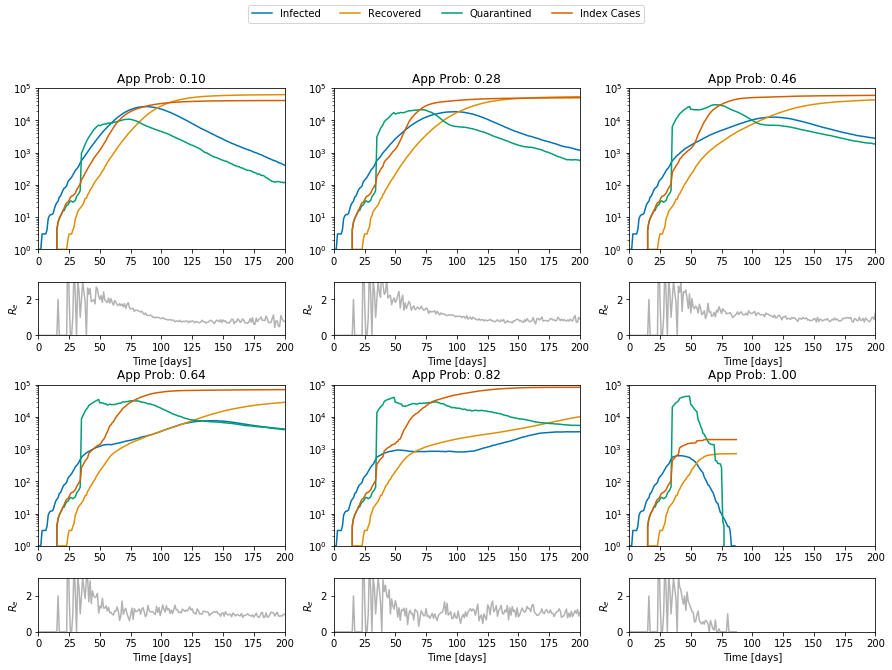

In [19]:
fig = plt.figure(figsize=(15, 10))
colors = sns.color_palette("colorblind", 4)
labels = ["App Prob: {:.2f}".format(app_prob) for app_prob in app_probs]

gs = gridspec.GridSpec(2, 3)

for i, (result, label) in enumerate(zip(all_stats, labels)):
    
    gs_spec = gs[i // 3, i % 3]
    
    gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs_spec, height_ratios=[3, 1], hspace=0.3)
    ax = fig.add_subplot(gs2[0])
    ax2 = fig.add_subplot(gs2[1])
    
    ax.plot(result["is_infected"], color=colors[0])
    ax.plot(result["is_recovered"], color=colors[1])
    ax.plot(result["is_quarantined"], color=colors[2])
    ax.plot(result["is_index_case"], color=colors[3])
    ax2.plot(result["Re"], color="k", alpha=0.3)
        
    ax2.set_xlabel("Time [days]")
    ax.set_title(label)
    ax.set_ylim(1, 1E5)
    ax.set_xlim(0, 200)
    ax.set_yscale("log")
    
    ax2.set_xlim(0, 200)
    ax2.set_ylim(0, 3)
    ax2.set_ylabel("$R_e$")
    
labels = ["Infected", "Recovered", "Quarantined", "Index Cases"]
proxies = [Line2D([], [], color=color) for color in colors]
fig.legend(proxies, labels, loc="upper center", ncol=4)
plt.savefig(os.path.join(PICS, "index_cases_app_prob_rnd_test.png"), dpi=150)

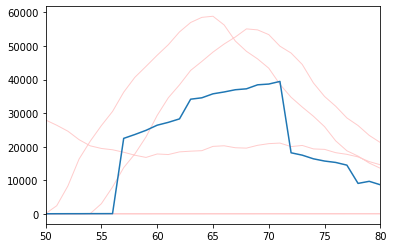

In [75]:
plt.plot(data_cpp.iloc[:1000]["day"], data_cpp.iloc[:1000][" fNQuarantineToday"], color="r", alpha=0.2, lw=1)
plt.xlim(50, 80)
plt.plot(stats["is_quarantined"])
#plt.semilogy()

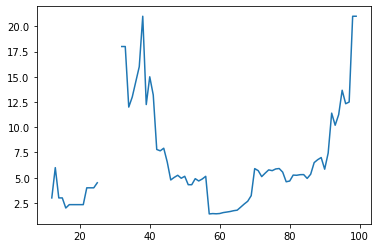

In [62]:
plt.plot(stats["is_infected"] / stats["is_infected_is_quarantined"])


In [84]:
data_cpp.columns

Index(['day', ' fNSusceptible', ' fNExposed', ' fNInfectious', ' fNRecovered',
       ' fNTraced', ' fNReported', ' feffectiveR', ' feffectiveRUncertainty',
       ' fNQuarantineToday'],
      dtype='object')

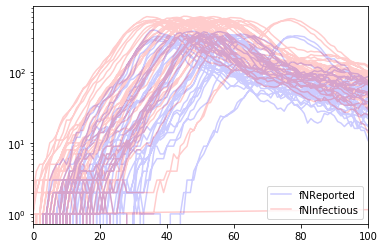

In [85]:
plt.plot(data_cpp["day"], data_cpp[" fNReported"], color="b", alpha=0.2, label="fNReported")
plt.plot(data_cpp["day"], data_cpp[" fNInfectious"], color="r", alpha=0.2, label="fNInfectious")
#plt.plot(data_cpp["day"], data_cpp[" fNQuarantineToday"], color="r", alpha=0.2, label="fNQuarantineToday")
plt.semilogy()
plt.xlim(0, 100)
plt.legend()


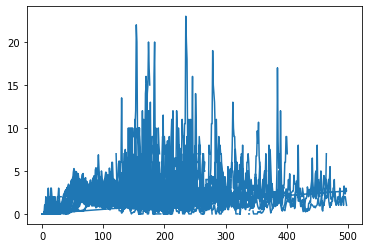

In [151]:
plt.plot(data_cpp["day"],  data_cpp[" fNReported"] / data_cpp[" fNExposed"])


In [100]:
results = sim_config(conf_1, 15)

(0, 200)

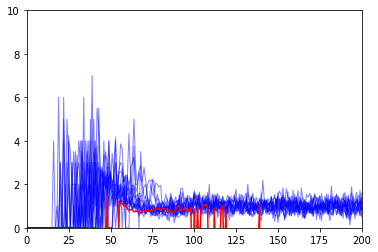

In [125]:

for stats in results:
    plt.plot(stats["Re"], color="b", lw=1, alpha=0.5)

plt.plot(data_cpp.groupby("day")[" feffectiveR"].mean(), color="r")
plt.ylim(0, 10)
plt.xlim(0, 200)

(0, 10)

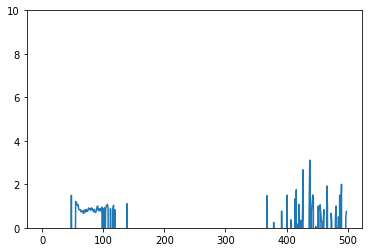

In [122]:

plt.ylim(0, 10)

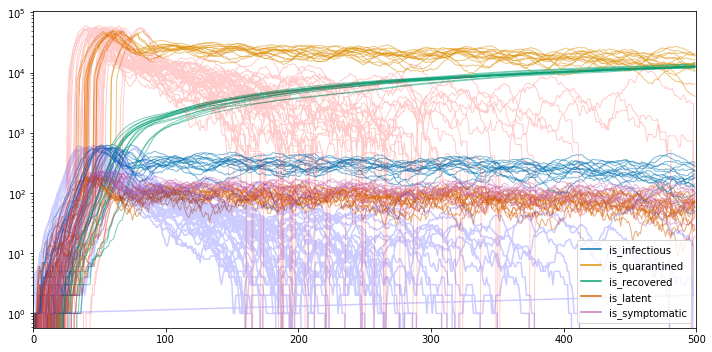

In [105]:
plt.figure(figsize=(10, 5))
colors = sns.color_palette("colorblind", 8)

fields = ["is_infectious", "is_quarantined", "is_recovered", "is_latent", "is_symptomatic"]

for stats in results:
    for field, color in zip(fields, colors):
        plt.plot(stats[field], color=color, lw=1, alpha=0.5)
proxies = []
for field, color in zip(fields, colors):
    proxies.append(Line2D([], [], label=field, color=color))
    
plt.legend(proxies, fields)
plt.semilogy()

plt.plot(data_cpp["day"], data_cpp[" fNInfectious"], color="b", alpha=0.2, )
plt.plot(data_cpp["day"], data_cpp[" fNQuarantineToday"], color="r", alpha=0.2, lw=1)

plt.xlim(0, 500)
plt.tight_layout()
plt.savefig("comp.png", dpi=150)

In [21]:
all_results = []
for config in configs:
    all_results.append(sim_config(config, 20))
    

In [22]:
sum_stats = []
for res in all_results:
    tot_infs = []
    for result in res:
        tot_inf_index = min(365, len(result["is_infected"])-1)
        tot_infs.append((result["is_infected"][tot_inf_index]+result["is_recovered"][tot_inf_index]+result["is_recovering"][tot_inf_index]))
    sum_stats.append(tot_infs)

In [175]:
for sstats in sum_stats:
    print(sstats)

[27040, 26087, 27922, 26393, 26210]
[15, 3747, 2, 1, 5]
[10312, 8984, 4, 9394, 4]
[20109, 19177, 19342, 4, 2]
[5578, 1, 7035, 1, 5585]
[23152, 22282, 1, 1, 2]


In [23]:
data_cpp = pd.read_csv("Sum_CovidSimMC_1346.csv")

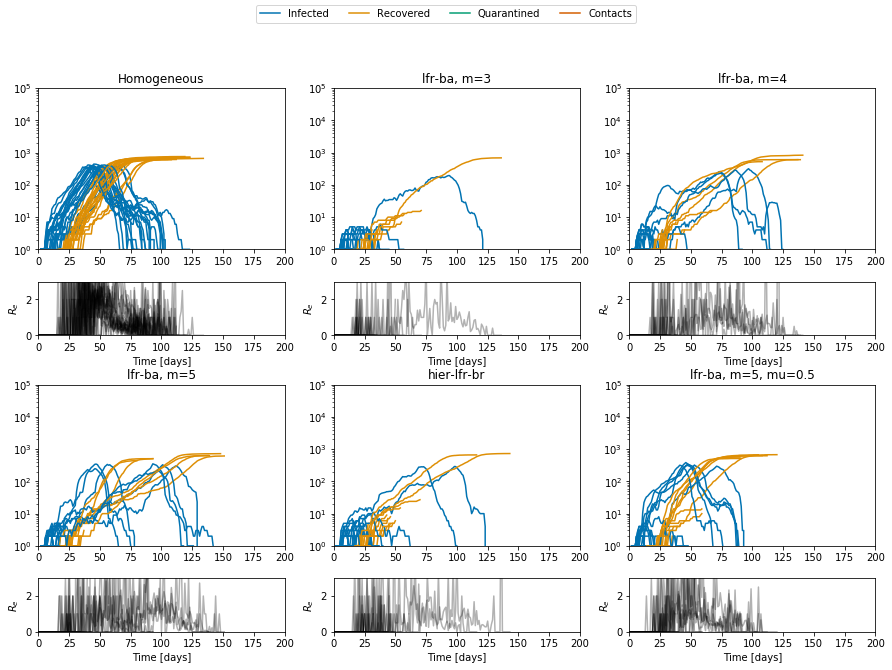

In [30]:
fig = plt.figure(figsize=(15, 10))
colors = sns.color_palette("colorblind", 4)
labels = ["Homogeneous", "lfr-ba, m=3", "lfr-ba, m=4", "lfr-ba, m=5", "hier-lfr-br", "lfr-ba, m=5, mu=0.5"]

gs = gridspec.GridSpec(2, 3)

for i, (res, label) in enumerate(zip(all_results, labels)):
    
    gs_spec = gs[i // 3, i % 3]
    
    gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs_spec, height_ratios=[3, 1], hspace=0.3)
    ax = fig.add_subplot(gs2[0])
    ax2 = fig.add_subplot(gs2[1])
    
    
    for result in res:
        ax.plot(result["is_infectious"], color=colors[0])
        ax.plot(result["is_recovered"], color=colors[1])
        #ax.plot(result["is_quarantined"], color=colors[2])
        #ax.plot(result["contacts"], color=colors[3])
        
        #ax.plot(data_cpp["day"], data_cpp[" fNInfectious"], color=colors[0], ls="--", alpha=0.3)
        #ax.plot(data_cpp["day"], data_cpp[" fNRecovered"], color=colors[1], ls="--", alpha=0.3)
        ax2.plot(result["Re"], color="k", alpha=0.3)
    ax2.set_xlabel("Time [days]")
    ax.set_title(label)
    ax.set_ylim(1, 1E5)
    ax.set_xlim(0, 200)
    ax.set_yscale("log")
    
    ax2.set_xlim(0, 200)
    ax2.set_ylim(0, 3)
    ax2.set_ylabel("$R_e$")
    

    
labels = ["Infected", "Recovered", "Quarantined", "Contacts"]
proxies = [Line2D([], [], color=color) for color in colors]
fig.legend(proxies, labels, loc="upper center", ncol=4)
plt.savefig(os.path.join(PICS, "social_graph_comp.png"), dpi=150)

In [36]:
for conf in configs:
    conf["population"]["re-use population"] = True
    conf["population"]["store population"] = False
    
    contagion = Contagion(conf)
    if hasattr(contagion.pop, "_graph"):
        graph = contagion.pop._graph
        plt.plot(nx.degree_histogram(graph))
    print(nx.average_shortest_path_length(graph))
plt.loglog()

KeyboardInterrupt: 

In [ ]:
networkx.algorithms.connectivity.kcomponents.k_components

In [ ]:
contagion = Contagion(conf_4)